# RGB image compression

Insights on compressing color images with PNG in the RGB domain.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
#!pwd
!ln -sf ~/quantization/deadzone_quantizer.py .
!ln -sf ~/quantization/midtread_quantizer.py .
!ln -sf ~/quantization/midrise_quantizer.py .
!ln -sf ~/quantization/companded_quantizer.py .
!ln -sf ~/quantization/distortion.py .
!ln -sf ~/quantization/information.py .
!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/image_3.py .
!ln -sf ~/MRVC/src/image_1.py .
!ln -sf ../common.py .
import deadzone_quantizer as deadzone
import midtread_quantizer as midtread
import midrise_quantizer as midrise
import companded_quantizer as companded
import distortion
import image_3 as RGB
import image_1 as gray
import colored
import common

## Configuration

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
#fn = home + "/MRVC/sequences/stockholm/"
fn = home + "/MRVC/sequences/lena_color/"

components = ['R', 'G', 'B']

#Q_steps = range(256, 0, -1)
Q_steps = [2**i for i in range(7, -1, -1)] # Quantization steps (simulating bit-plane encoding)
quantizer = midtread
#quantizer = deadzone
#quantizer = midrise

#quantizer = companded
#Q_steps = [2**i for i in range(16, -1, -1)] # Quantization steps (simulating bit-plane encoding)

print(Q_steps)

[128, 64, 32, 16, 8, 4, 2, 1]


Notice that non embbeded quatization (using steps thar are different from a power of 2) steps (can produce loops in the RD curves due to the non-linearity of the integer division performed in the quantization).

## Read the image and show it

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 
int16
255 1


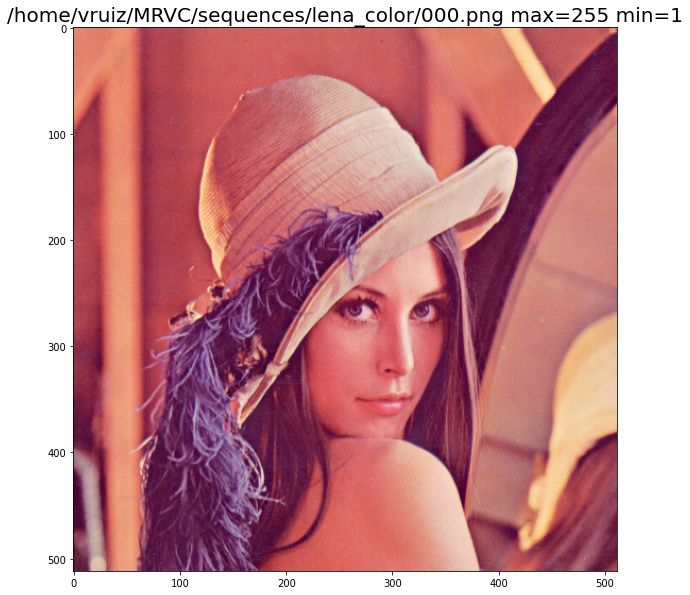

In [3]:
img = RGB.read(fn).astype(np.int16) # 8 bits/components is not sufficient to shift the components to [-128, 127]
print(img.dtype)
print(img.max(), img.min())
common.show(img, fn + "000.png")

## Show also some quantizations

Used quantization indexes: [-1  0  1]


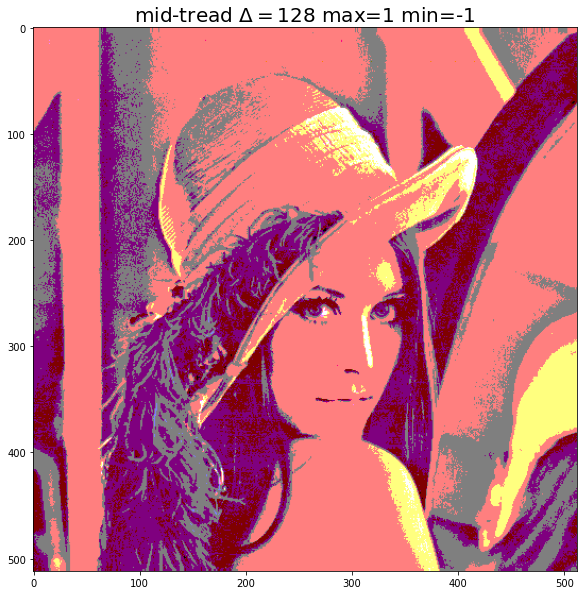

In [4]:
QS = 128 # Quantization Step
_img = img.astype(np.int16)-128 # Quantized data must be centered at 0
y, k = quantizer.quan_dequan(_img, QS)
print("Used quantization indexes:", np.unique(k))
common.show(k, f"{quantizer.name} $\\Delta={QS}$")

Used quantization indexes: [-2 -1  0  1  2]


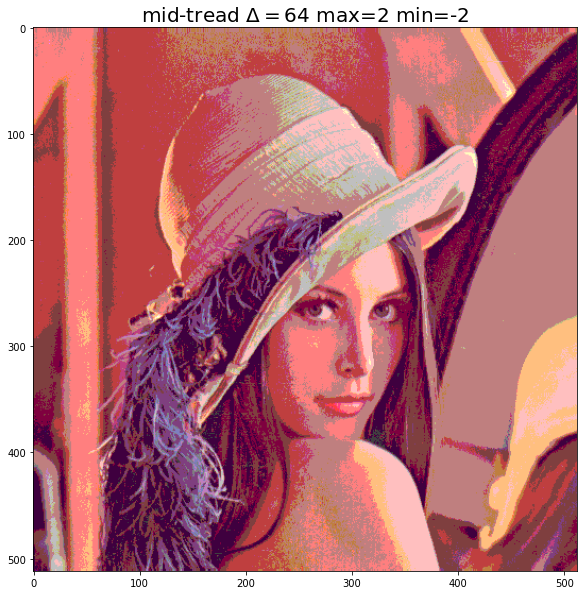

In [5]:
QS = 64 # Quantization Step
_img = img.astype(np.int16)-128 # Quantized data must be centered at 0
y, k = quantizer.quan_dequan(_img, QS)
print("Used quantization indexes:", np.unique(k))
common.show(k, f"{quantizer.name} $\\Delta={QS}$")

## RD curve using same $\Delta$ for each RGB channel ($\Delta_{\text{R}} = \Delta_{\text{G}} = \Delta_{\text{B}}$)
To see the contribution of each channel to the RD curve.

In [6]:
def same_delta_RD_curve(RGB_img, Q_steps, quantizer):
    RGB_img -= 128
    points = []
    for Q_step in Q_steps:
        y, k = quantizer.quan_dequan(RGB_img, Q_step)
        k = (k + 128).astype(np.uint8) # Only positive components can be written in an PNG file
        print("Quantization indexes: ", np.unique(k))
        rate = common.bits_per_color_pixel(k, str(Q_step) + '_') # Remember that k has 3 components
        _distortion = distortion.MSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

#same_delta_RD_points = same_delta_RD_curve(img - 128, Q_steps, quantizer)
same_delta_RD_points = same_delta_RD_curve(img, Q_steps, quantizer)

Quantization indexes:  [127 128 129]
image_3.write: /tmp/128_000.png (512, 512, 3) uint8 57657 
q_step=128, rate=1.759552001953125 bits/pixel, distortion=1490.7
Quantization indexes:  [126 127 128 129 130]
image_3.write: /tmp/64_000.png (512, 512, 3) uint8 87096 
q_step= 64, rate=2.657958984375 bits/pixel, distortion= 359.2
Quantization indexes:  [124 125 126 127 128 129 130 131 132]
image_3.write: /tmp/32_000.png (512, 512, 3) uint8 122481 
q_step= 32, rate=3.737823486328125 bits/pixel, distortion=  83.4
Quantization indexes:  [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136]
image_3.write: /tmp/16_000.png (512, 512, 3) uint8 180182 
q_step= 16, rate=5.49871826171875 bits/pixel, distortion=  21.0
Quantization indexes:  [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
image_3.write: /tmp/8_000.png (512, 512, 3) uint8 249644 
q_step=  8, rate=7.6185302734375 bits/pixel, distortion= 

## For further comparisons

In [7]:
print(quantizer.name)
with open(f"RGB_same_delta_{quantizer.name}_RD_points.txt", 'w') as f:
    for item in same_delta_RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

mid-tread


## Comparing all quantizers
You must have run the previous cells for the different quantizers.

In [ ]:
RGB_midrise = []
with open(f"RGB_same_mid-rise_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midrise.append((float(rate), float(_distortion)))

In [ ]:
RGB_deadzone = []
with open(f"RGB_same_dead-zone_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_deadzone.append((float(rate), float(_distortion)))

In [ ]:
RGB_midtread = []
with open(f"RGB_same_mid-tread_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midtread.append((float(rate), float(_distortion)))

In [ ]:
RGB_companded = []
with open(f"RGB_same_companded_RD_points.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_companded.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_midrise), c='g', marker='o', label="Mid-rise", linestyle="dashed")
pylab.plot(*zip(*RGB_deadzone), c='m', marker='x', label="Dead-zone", linestyle="dotted")
pylab.plot(*zip(*RGB_midtread), c='r', marker='x', label="Mid-read", linestyle="dotted")
pylab.plot(*zip(*RGB_companded), c='b', marker='x', label="Companded", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

The RD performance of the four quantizers in the RGB domain is similar, but the companded quantizer needs extra bits for representing the source losslessly. This is a consequence of the floating point arithmetic used in the compressor and the decompressor.

## Generation of the "optimal" RD curve

In general (but not necessary in all cases), the contribution of the components to the quality of the reconstruction can be different. This contribution is expressed in terms of RD, "selecting", for each QS, first the component that has the highest RD slope. Thus, in general (in this case for all cases), the "optimal" RD curve using the following procedure:

1. The RD curve of each RGB channel is computed, for a number of quantization steps.
2. The RD points are sorted by slopes.

Notice that must be true that the RGB components are additive (colors are obtained by a linear combination of Red, Green, and Blue, i.e., if we increment the quality of one component, the quality of the reconstruction is increases in such increment also). Otherwise, the distortion must be computed considering that his is false.

### RD curves of each RGB channel

In [ ]:
def RD_curve(RGB_img, Q_steps, component, components, quantizer):
    RD_points = []
    component_index = components.index(component)
    for Q_step in Q_steps:
        component_img = RGB_img[..., component_index]
        dequantized_component_img, k = quantizer.quan_dequan(component_img, Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_gray_pixel(k, component + str(Q_step) + '_')
        _distortion = distortion.MSE(component_img, dequantized_component_img)
        # We can measure the distortion in the RGB domain because it is additive
        RD_points.append((rate, _distortion, component, Q_step))
        print(f"Q_step={Q_step:>3}, rate={rate:>.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def R_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve(RGB_img, Q_steps, 'R', components, quantizer)

def G_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve(RGB_img, Q_steps, 'G', components, quantizer)

def B_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve(RGB_img, Q_steps, 'B', components, quantizer)

In [ ]:
print(quantizer.name, "red")
R_points = R_RD_curve(img - 128, Q_steps, components, quantizer)

In [ ]:
print(quantizer.name, "green")
G_points = G_RD_curve(img - 128, Q_steps, components, quantizer)

In [ ]:
print(quantizer.name, "blue")
B_points = B_RD_curve(img - 128, Q_steps, components, quantizer)

In [ ]:
pylab.figure(dpi=150)
#pylab.scatter(*zip(*[(i[0], i[1]) for i in R_points]), c='r', marker='.', s=0.5, label='R')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in G_points]), c='g', marker='.', s=0.5, label='G')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in B_points]), c='b', marker='.', s=0.5, label='B')              
pylab.plot(*zip(*[(i[0], i[1]) for i in R_points]), c='r', marker='.', label=f"R", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in G_points]), c='g', marker='.', label=f"G", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in B_points]), c='b', marker='.', label=f"B", linestyle="dashed")
#pylab.plot(*zip(*[(i[0], i[1]) for i in R_points_2]), c='r', marker='x', label=f"R ({quantizer_2.name})", linestyle="dotted")              
#pylab.plot(*zip(*[(i[0], i[1]) for i in G_points_2]), c='g', marker='x', label=f"G ({quantizer_2.name})", linestyle="dotted")
#pylab.plot(*zip(*[(i[0], i[1]) for i in B_points_2]), c='b', marker='x', label=f"B ({quantizer_2.name})", linestyle="dotted")
pylab.title(f"RD contribution of each component ({quantizer.name})")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

### Compute the slopes

In [ ]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 0.0, '', -1)] + RD_points
    counter = 0
    RD_slopes = [(9.0E9, RD_points[0])]
    points_iterator = iter(RD_points)
    next(points_iterator)
    for i in points_iterator:
        BPP = i[0] # Rate 
        #print(RD_points[counter])
        #delta_BPP = BPP - extended_RD_points[counter][0]
        delta_BPP = BPP - RD_points[counter][0]
        MSE = i[1] # Distortion
        #delta_MSE = MSE - extended_RD_points[counter][1] 
        delta_MSE = MSE - RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = abs(delta_MSE/delta_BPP)
        else:
            slope = 0
        component = i[2]
        q_step = i[3]
        print((slope, i), delta_MSE, delta_BPP)
        RD_slopes.append((slope, i))
        counter += 1
    #RD_slopes.append((0.0, (0.0, RD_points[-1][2], 1)))
    return RD_slopes

R_slopes = compute_slopes(R_points)
G_slopes = compute_slopes(G_points)
B_slopes = compute_slopes(B_points)

In [ ]:
R_slopes

In [ ]:
G_slopes

In [ ]:
B_slopes

### Merge the RD slopes and sort them (by slope)

In [ ]:
all_slopes = R_slopes + G_slopes + B_slopes
sorted_slopes = sorted(all_slopes, key=lambda x: x[0])[::-1]

In [ ]:
sorted_slopes

### Build the RD curve

At this point we have a list of RD points sorted by their slopes and we have two alternatives to compute the RD curve:

1. Suppose that the distortion of the reconstructed (dequantized) image is the sum of the distortions of each component, and do the same for the bit-rate.
2. Suppose that, because we are compressing a RGB image, the bit-rate of the compressed image can be slighly smaller than the addition of the bit-rates of the compressed components, basically because we will avoid extra headers.

The second alterntive has been used because it is more accurate.

In [ ]:
# Recompute 
def get_RD_curve_sorted_by_slopes(RGB_img, sorted_slopes, components, quantizer):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    #Q_steps_per_component = [128, 128, 128] # This should generate a black image.
    for i in sorted_slopes:
        k = np.empty_like(RGB_img)
        y = np.empty_like(RGB_img)
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c, QS in zip(components, Q_steps_per_component):
            y[..., components.index(c)], k[..., components.index(c)] = quantizer.quan_dequan(RGB_img[..., components.index(c)], QS)
            #print(c, QS,components.index(c))
            #for _y in range(10):
            #    for _x in range(10):
            #        print(RGB_img[_y, _x, components.index(c)], y[_y,_x, components.index(c)], end=' ')
            #    print()
        #y, k = quantizer.quan_dequan(RGB_img, Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_color_pixel(k, str(Q_steps_per_component) + '_')
        _distortion = distortion.MSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RD_points_sorted_by_slopes = get_RD_curve_sorted_by_slopes(img - 128, sorted_slopes, components, quantizer)

## For further comparisons

In [ ]:
print(quantizer.name)
with open(f"RGB_sorted_{quantizer.name}.txt", 'w') as f:
    for item in RD_points_sorted_by_slopes:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's compare!

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_by_slopes), c='g', marker='o', label="Sorted by slope", linestyle="dashed")
pylab.plot(*zip(*same_delta_RD_points), c='m', marker='x', label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance ({quantizer.name})")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Conclusion

In the RGB domain, the optimal RD curve matches the constant quantization RD curve because the 3 components have the same weight in the contribution to the quality the reconstruction. However, we have more OTPs (Optimal Truncation Points) in the optimal one.

## Comparing all quantizers

In [ ]:
RGB_midrise = []
with open(f"RGB_mid-rise.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midrise.append((float(rate), float(_distortion)))

In [ ]:
RGB_deadzone = []
with open(f"RGB_dead-zone.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_deadzone.append((float(rate), float(_distortion)))

In [ ]:
RGB_midtread = []
with open(f"RGB_mid-tread.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_midtread.append((float(rate), float(_distortion)))

In [ ]:
RGB_companded = []
with open(f"RGB_companded.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_companded.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_midrise), c='g', marker='o', label="Mid-rise", linestyle="dashed")
pylab.plot(*zip(*RGB_deadzone), c='m', marker='x', label="Dead-zone", linestyle="dotted")
pylab.plot(*zip(*RGB_midtread), c='r', marker='x', label="Mid-read", linestyle="dotted")
pylab.plot(*zip(*RGB_companded), c='b', marker='x', label="Companded", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Ignore the rest ...

In [ ]:
def accumulate_rate(points_sorted_by_slopes):
    optimal_points = []
    accumulated_BR = 0.0
    for i in points_sorted_by_slopes:
        BPP = i[1][0]; MSE = i[1][1]
        accumulated_BR += BPP
        optimal_points.append((accumulated_BR, MSE))
    return optimal_points

optimal_points = accumulate_rate(optimal_slopes)

In [ ]:
optimal_points

## Compute slopes

In [ ]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 9.0E9, '', -1)] + RD_points
    counter = 0
    RD_slopes = []
    for i in RD_points:
        BPP = i[0] # Rate 
        print(RD_points[counter])
        delta_BPP = BPP - extended_RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - extended_RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = delta_MSE/delta_BPP
        else:
            slope = 0
        RD_slopes.append((slope, i[2], i[3]))
        counter += 1
    return RD_slopes

RD_slopes = compute_slopes(sorted_RD_points)

In [ ]:
RD_slopes

In [ ]:
print(RD_points)

In [ ]:
with open('RGB.txt', 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

In [ ]:
k, y = q_deq(img, 64)
show(y, "")

## RD curves of each channel

In [ ]:
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        R_frame = RGB_frame[:,:,0]
        k, dequantized_R_frame = q_deq(R_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(R_frame, dequantized_R_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        G_frame = RGB_frame[:,:,1]
        k, dequantized_G_frame = q_deq(G_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(G_frame, dequantized_G_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        B_frame = RGB_frame[:,:,2]
        k, dequantized_B_frame = q_deq(B_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(B_frame, dequantized_B_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
only_B_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='Only R')              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='Only G')              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='Only B')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

The $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$ quantization scheme is near optimal because the slope at the different quantization points is almost the same. This can be seen in the next experiment

## Testing a different quantization configuration

In [ ]:
N = 6
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='$\Delta_{\mathrm{R}}~\mathrm{varies},~\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='$\Delta_{\mathrm{G}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='$\Delta_{\mathrm{B}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

As it can be seen, the best configuration matches $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$.

Lo que hay que hacer es calcular el slope para cada OTP (Optimal Truncated Point) de cada canal, ordenarlos y trazar la curva RD. Esto nos daría la curva RD óptima.